Using the main.ipynb for training was too chaotic. This file will be ONLY contain code that is absolutely necessary for finding out how to train the Kalman Filters.

In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 448, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 448 (delta 79), reused 118 (delta 28), pack-reused 256 (from 1)
Receiving objects: 100% (448/448), 11.99 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (226/226), done.
Filtering content: 100% (14/14), 1.75 GiB | 66.06 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d602d9a65a05dc7ad83567b98012b9f29655d100f0b4a4cb62f66a0e33e820fe
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 13.9 MB/s eta 0:00:00


In [62]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn as nn
import itertools
from pykalman import KalmanFilter

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from models.statistical_models import default_normalize
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

In [11]:
# NOTE: all the functions used here are explained in much more detail in src/main.ipynb, but this notebook is simply focused on finding how to ge the Transformer model to work as I wish.
startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
# Note about pairs_timeseries_df: the timeseries output on which we should train are found in the key "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

Processing pairs: 100%|██████████| 820/820 [01:41<00:00,  8.12it/s]


Completed 820 pairs


/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

In [20]:
pairs_data_filtered

[(('PFF', 'IGSB'), np.float64(3.0163860840139413e-06)),
 (('IGIB', 'IFGL'), np.float64(3.1322038155348414e-06)),
 (('USIG', 'PPH'), np.float64(2.621351855041312e-05)),
 (('USIG', 'PHO'), np.float64(0.0002540997299264048)),
 (('IGIB', 'IGF'), np.float64(0.00037978034092713377)),
 (('IGSB', 'EMB'), np.float64(0.0005964786506590314)),
 (('IGIB', 'TLT'), np.float64(0.0007039730162819213)),
 (('IFGL', 'IGSB'), np.float64(0.0007860628026761489)),
 (('EMB', 'TLT'), np.float64(0.000824207180844204)),
 (('SHV', 'PEY'), np.float64(0.0008390644259399934)),
 (('EMB', 'SMH'), np.float64(0.0009269940276486267)),
 (('IGSB', 'PEY'), np.float64(0.0009728025177510877)),
 (('PFF', 'IGIB'), np.float64(0.0010572018262853824)),
 (('IGIB', 'SMH'), np.float64(0.001142523000059977)),
 (('IGIB', 'SOXX'), np.float64(0.0011449063816258095)),
 (('IGSB', 'SHV'), np.float64(0.0012639632665603503)),
 (('SHV', 'DVY'), np.float64(0.001275723390097672)),
 (('IGSB', 'PPH'), np.float64(0.0013347040611567356)),
 (('SHV', '

In [43]:
# Set a bunch of variables based on the existing function `execute_kalman_workflow` (Note: Some are changed already)
pair_data: pd.DataFrame = pairs_timeseries_df
col_s1: str = "S1_close"
col_s2: str = "S2_close"
burn_in: int = 30
train_frac: float = 0.90
dev_frac: float = 0.05   # remaining part is test
look_back: int = 1
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
return_datasets: bool = False
verbose: bool = True
add_technical_indicators: bool = True

In [91]:
def calculate_return_uncertainty(S1, S2, spread_pred_series, position_thresholds=None, clearing_thresholds=None,
                          long_windows=None, short_windows=None, return_for_plotting=False):
  if position_thresholds is not None and clearing_thresholds is not None:
      threshold_combinations = list(itertools.product(position_thresholds, clearing_thresholds))
      param_type = 'thresholds'
  elif long_windows is not None and short_windows is not None:
      threshold_combinations = list(itertools.product(long_windows, short_windows))
      param_type = 'windows'
  else:
      raise ValueError("Must specify either (position_thresholds and clearing_thresholds) or (long_windows and short_windows)")

  all_returns = []

  for a, b in threshold_combinations:
      if param_type == 'thresholds':
          returns = trade(
              S1=S1,
              S2=S2,
              spread=spread_pred_series,
              window_long=30,
              window_short=5,
              position_threshold=a,
              clearing_threshold=b
          )
          # print(f"Returns for (pt={a},ct={b}) -> {returns[-1]}")
      else:
          returns = trade(
              S1=S1,
              S2=S2,
              spread=spread_pred_series,
              window_long=a,
              window_short=b,
              position_threshold=0.8,
              clearing_threshold=0.2
          )
          # print(f"Returns for (wl={a},ws={b}) -> {returns[-1]}")

      all_returns.append(returns)

  # turn into numpy
  returns_array = np.vstack([np.array(r) for r in all_returns])

  # mean and stdev for plotting
  mean_returns = returns_array.mean(axis=0)
  std_returns = returns_array.std(axis=0)
  std_dev_pct = (std_returns / mean_returns[0]) * 100
  if return_for_plotting:
    return np.vstack([np.array(r) for r in all_returns]), param_type
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


def plot_return_uncertainty(S1, S2, spread_pred_series, test_index, look_back,
                            position_thresholds=None, clearing_thresholds=None,
                            long_windows=None, short_windows=None, verbose=False, plot_filepath_parent_dir=""):
    returns_array, param_type = calculate_return_uncertainty(
        S1, S2, spread_pred_series,
        position_thresholds, clearing_thresholds,
        long_windows, short_windows, return_for_plotting=True
    )

    mean_returns = returns_array.mean(axis=0)
    std_returns = returns_array.std(axis=0)
    time_axis_series = test_index

    std_dev_pct = (std_returns / mean_returns[0]) * 100

    if param_type == "thresholds":
        print(f"position threshold ({min(position_thresholds):.2f}-{max(position_thresholds):.2f}), "
              f"clearing threshold ({min(clearing_thresholds):.2f}-{max(clearing_thresholds):.2f})")
    else:
        print(f"short window ({min(short_windows)}-{max(short_windows)}), "
              f"long window ({min(long_windows)}-{max(long_windows)})")
    print(f"Return % over period: {100 * ((mean_returns[-1] - mean_returns[0]) / mean_returns[0]):.2f}% ± {std_dev_pct[-1]:.2f}%")
    print(f"Return % YoY (mean and std dev): {(mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1:.2%} ± "
          f"{((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns))):.2%}")

    plt.figure(figsize=(10, 6))
    plt.plot(time_axis_series, mean_returns, label='Mean Strategy Returns')
    plt.fill_between(time_axis_series, mean_returns - std_returns, mean_returns + std_returns,
                     alpha=0.3, label='±1 Std Dev')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    if param_type == "thresholds":
        plt.title(f"Trading Strategy Returns - position threshold ({min(position_thresholds):.2f}-{max(position_thresholds):.2f}), "
                  f"clearing threshold ({min(clearing_thresholds):.2f}-{max(clearing_thresholds):.2f})")
    else:
        plt.title(f"Trading Strategy Returns - short window ({min(short_windows)}-{max(short_windows)}), "
                  f"long window ({min(long_windows)}-{max(long_windows)})")
    plt.legend()
    filename = f"plot_{param_type}.png"
    filepath = os.path.join(plot_filepath_parent_dir, filename)
    plt.savefig(filepath)
    if verbose:
        print(f"Saved plot to {filepath}")
    return filename


def kalman_filter_regression_multivariate(X, y, delta=1e-4, obs_cov=1e-2):
    T, d = X.shape
    transition_matrix = np.eye(d)
    transition_covariance = delta * np.eye(d)
    # initially coefficients at zero
    initial_state_mean = np.zeros(d)
    initial_state_covariance = 1e3 * np.eye(d)
    observation_covariance = obs_cov
    observation_matrices = X[:, np.newaxis, :]

    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrices,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance,
        transition_covariance=transition_covariance,
        observation_covariance=obs_cov,
        n_dim_obs=1,
        n_dim_state=d
    )

    state_means, _ = kf.filter(y)
    return state_means

def execute_kalman_workflow(
  pair_data: pd.DataFrame,
  col_s1: str = "S1_close",
  col_s2: str = "S2_close",
  burn_in: int = 30,
  train_frac: float = 0.90,
  dev_frac: float = 0.05,
  look_back: int = 1,
  denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den,
  scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler,
  scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)},
  normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize,
  delta: float = 1e-3,
  obs_cov_reg: float = 2.,
  trans_cov_avg: float = 0.01,
  obs_cov_avg: float = 1.,
  return_datasets: bool = False,
  verbose: bool = True,
  add_technical_indicators: bool = True
):
  # Check whether everything is present as expected (good practice, and gives useful exceptions)
  required = {col_s1, col_s2}
  if not required.issubset(pair_data.columns):
      raise KeyError(f"pair_data must contain {required}")

  keep_cols = [c for c in pair_data.columns if c not in ("date",)]
  df = pair_data[keep_cols].iloc[burn_in:].copy()

  total_len = len(df)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train = df.iloc[:train_size]
  dev   = df.iloc[train_size:train_size + dev_size]
  test  = df.iloc[train_size + dev_size:]

  if verbose:
      print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

  if denoise_fn is not None: # denoise using wavelet denoising
      train = pd.DataFrame({col: denoise_fn(train[col]) for col in keep_cols})

  if scaler_factory is not None:
      scaler = scaler_factory(**(scaler_kwargs or {}))
  else:
      scaler = None


  trainX_untr, trainX, trainY_untr, trainY = create_dataset(train.values, scaler=scaler, look_back=look_back)
  devX_untr,   devX,   devY_untr,   devY   = create_dataset(dev.values,  scaler=scaler, look_back=look_back)
  testX_untr,  testX,  testY_untr,  testY  = create_dataset(test.values, scaler=scaler, look_back=look_back)

  if add_technical_indicators:
      # Predict S1_close using all other columns except S1_close as X, making it multivariate regression with a very large number of variables (the technical indicators)
      y_train = train[col_s1].values
      X_train = train.drop(columns=[col_s1]).values # all input variables

      # do the same for dev and test
      y_dev = dev[col_s1].values
      X_dev = dev.drop(columns=[col_s1]).values
      y_test = test[col_s1].values
      X_test = test.drop(columns=[col_s1]).values

      # apply scaler to all versions of the input
      if scaler is not None:
          X_train = scaler.fit_transform(X_train)
          X_dev = scaler.transform(X_dev)
          X_test = scaler.transform(X_test)

      # recursive least squares multivariate regression, using the function
      beta_t = kalman_filter_regression_multivariate(X_train, y_train, delta=delta)
      forecast_train = np.sum(X_train * beta_t, axis=1)
      forecast_dev   = np.sum(X_dev * beta_t[-len(X_dev):], axis=1)
      forecast_test  = np.sum(X_test * beta_t[-len(X_test):], axis=1)

      if look_back == 1:
          forecast_test_list = [np.array([v]) for v in forecast_test] # this way of calculating MSE is a bit messy and too many steps, but it works in the workflow now, so we'll keep it like this.
          testY_arr = np.array(y_test).reshape(-1, 1)
          testY_list = [np.array([v]) for v in y_test]
          test_mse = acc_metric(testY_list, forecast_test_list)

          # # repeat for dev / validaiton
          forecast_dev_list = [np.array([v]) for v in forecast_dev]
          devY_arr = np.array(y_dev).reshape(-1, 1)
          devY_list = [np.array([v]) for v in y_dev]
          val_mse = acc_metric(devY_list, forecast_dev_list)
      else:
          print("Warning: look_back > 1 not yet implemented. Returning None for mse.")
          test_mse, val_mse = None, None
  else:
    # get beta_t, the Kalman-filtered regression coefficients
    beta_t = kalman_filter_regression(
        kalman_filter_average(pair_data[col_s1],
                              transition_cov=trans_cov_avg,
                              obs_cov=obs_cov_avg),
        kalman_filter_average(pair_data[col_s2],
                              transition_cov=trans_cov_avg,
                              obs_cov=obs_cov_avg),
        delta=delta,
        obs_cov=obs_cov_reg
    )[:, 0]

    kalman_spread = normalise_fn(
        pair_data[col_s1] + pair_data[col_s2] * beta_t)

    forecast_train = kalman_spread[:len(trainX)].to_numpy() # Though the variable `forecast_train` is never directly used as a variable, the data for it WAS used, during kalman filter averaging and regression
    forecast_dev   = kalman_spread[len(trainX):len(trainX) + len(devX)].to_numpy()
    forecast_test = kalman_spread[-len(testX):].to_numpy()

    if look_back == 1:
        yhat_KF_mse = [np.array([v]) for v in forecast_test]

        # Original normalisation: operate directly on the list-of-arrays
        testY_arr  = np.array(testY_untr)               # shape (N,1)
        testY_norm = (testY_arr - testY_arr.mean()) / testY_arr.std()

        # Convert back to list-of-arrays so acc_metric sees the same layout
        testY_norm_list = [row for row in testY_norm]

        test_mse = acc_metric(testY_norm_list, yhat_KF_mse)

        yhat_KF_dev_mse = [np.array([v]) for v in forecast_dev]
        devY_arr = np.array(devY_untr)
        devY_norm = (devY_arr - devY_arr.mean()) / devY_arr.std()
        devY_norm_list = [row for row in devY_norm]
        val_mse = acc_metric(devY_norm_list, yhat_KF_dev_mse)
    else:
        print("Warning: look_back > 1 not yet implemented. Returning None for mse.")
        test_mse = None
        val_mse = None

  ### TRADING ###
  # Use forecast_test to get the trading results
  print(f"len_spread: {len(pd.Series(forecast_test, index=test.index))}")
  print(f"len(S1): {len(test['S1_close'].iloc[look_back:])}")
  returns = trade(
    S1 = test['S1_close'],
    S2 = test['S2_close'],
    spread = pd.Series(forecast_test, index=test.index),
    window_long = 30,
    window_short = 5,
    position_threshold = 1.0,
    clearing_threshold = 0.5
  )
  print("Simulated P&L:", returns[-1])
  print(f"Return % over period: {100*((returns[-1] - returns[0]) / returns[0])}%")
  print(f"Return % YoY: {((returns[-1] / returns[0])**(365/len(returns)) - 1) * 100}")

  # next step: calculate std_dev_pct using the logic from plot_with_uncertainty. Then put that into two separate functions: calculate_yoy_uncertainty and a version of plot_with_uncertainty that uses calculate_yoy_uncertainty
  # position threshold (2.00-4.00), clearing threshold (0.30-0.70)
  min_position = 2.00
  max_position = 4.00
  min_clearing = 0.30
  max_clearing = 0.70
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)
  yoy_mean, yoy_std = calculate_return_uncertainty(test['S1_close'], test['S2_close'], pd.Series(forecast_test, index=test.index), position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)

  plot_filepath_parent_dir = os.path.join("data", "plots")


  yoy_returns_filename = plot_return_uncertainty(test['S1_close'], test['S2_close'], pd.Series(forecast_test, index=test.index), test.index, look_back, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds, verbose=verbose, plot_filepath_parent_dir=plot_filepath_parent_dir)
  plot_filenames = {
      "yoy_returns": yoy_returns_filename,
      "predicted_vs_actual_spread": None,
      "train_val_loss": None
  }
  if verbose:
    print(f"""
  Validation MSE: {val_mse}
  Test MSE: {test_mse}
  YOY Returns: {yoy_mean * 100:.2f}%
  YOY Std: {yoy_std * 100:.2f}%
  Plot filepath parent dir: {plot_filepath_parent_dir}
  Plot filenames: {plot_filenames}
    """)
  output: Dict[str, Any] = dict(
      val_mse=val_mse,
      test_mse=test_mse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      plot_filepath_parent_dir=plot_filepath_parent_dir,
      plot_filenames=plot_filenames
  )

  if return_datasets:
      output.update(
          dict(train=train, dev=dev, test=test,
                datasets=dict(
                    train=(trainX_untr, trainX, trainY_untr, trainY),
                    dev  =(devX_untr,   devX,   devY_untr,   devY),
                    test =(testX_untr,  testX,  testY_untr,  testY)
                ))
      )
  return output

In [82]:
# Useful idea for the dev/validation data: go through all pairs, pick the pair with the highest validation MSE, and use that pair for getting a test MSE.
results = []

from tqdm import tqdm

for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering test MSE (and returns) for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False)
    results.append((str(pairs_data_filtered[i][0]), output['val_mse']))

results.sort(key=lambda x: x[1])  # sort by MSE
x = 10
top_x = results[:x]
bottom_x = results[-x:]
combined = top_x + [('...', None)] + bottom_x
labels = [item[0] for item in combined]
values = [item[1] for item in combined]
plt.figure(figsize=(12, 6))
bars = plt.barh(labels, [v if v is not None else 0 for v in values], color='skyblue')

Gathering test MSE (and returns) for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys 

len_spread: 125
len(S1): 124
Simulated P&L: 95358.22467985237
Return % over period: -4.64177532014763%
Return % YoY: -12.86268271376706


Gathering test MSE (and returns) for different pairs..:   1%|          | 1/95 [00:01<01:43,  1.11s/it]/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

len_spread: 125
len(S1): 124
Simulated P&L: 137303.21312385495
Return % over period: 37.30321312385495%
Return % YoY: 150.51685451119545


Gathering test MSE (and returns) for different pairs..:   2%|▏         | 2/95 [00:02<01:42,  1.11s/it]/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

len_spread: 125
len(S1): 124
Simulated P&L: 86457.57207648858
Return % over period: -13.542427923511422%
Return % YoY: -34.39613474313224


Gathering test MSE (and returns) for different pairs..:   3%|▎         | 3/95 [00:03<01:41,  1.10s/it]/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

len_spread: 125
len(S1): 124
Simulated P&L: 114113.07168639044
Return % over period: 14.113071686390438%
Return % YoY: 46.58537108359626


Gathering test MSE (and returns) for different pairs..:   4%|▍         | 4/95 [00:04<01:44,  1.14s/it]


KeyboardInterrupt: 

/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

Split sizes — train: 2239, dev: 124, test: 125
len_spread: 125
len(S1): 124
Simulated P&L: 108604.71291714755
Return % over period: 8.604712917147554%
Return % YoY: 27.012757048548643
position threshold (2.00-4.00), clearing threshold (0.30-0.70)
Return % over period: 12.33% ± 1.57%
Return % YoY (mean and std dev): 40.06% ± 2.67%


ValueError: x and y must have same first dimension, but have shapes (125,) and (126,)

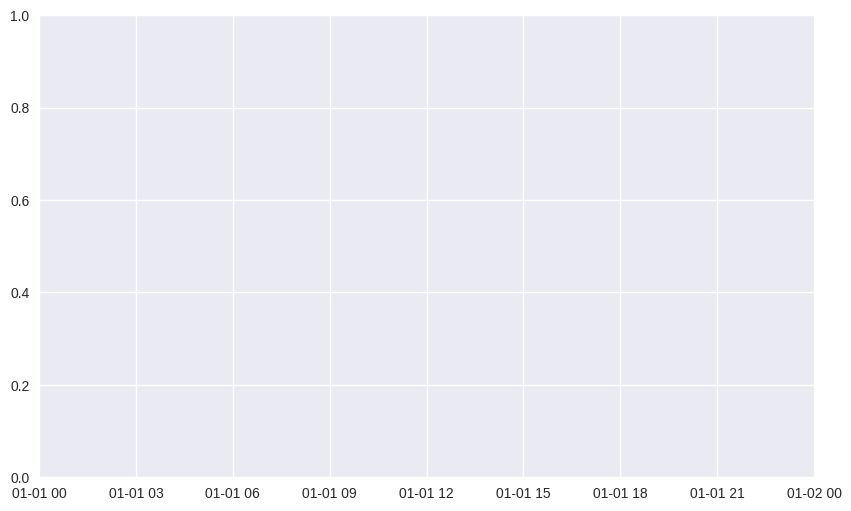

In [92]:
wanted_pair = ("PRFZ", "PEY")
for i in range(len(pairs_data_filtered)):
  best_iter = 60
ticker_a, ticker_b = pairs_data_filtered[best_iter][0][0], pairs_data_filtered[best_iter][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=True)

In [ ]:
def trade(
    S1: pd.Series,
    S2: pd.Series,
    spread: pd.Series, # model-predicted spread for the strategy
    window_long: int,
    window_short: int,
    initial_cash: float = 100000,
    position_threshold: float = 1.0,
    clearing_threshold: float = 0.5,
    risk_fraction: float = 0.1
) -> list:
    ma_long = spread.rolling(window=window_long, center=False).mean()
    ma_short = spread.rolling(window=window_short, center=False).mean()
    std = spread.rolling(window=window_short, center=False).std()
    zscore = (ma_long - ma_short)/std

    cash = initial_cash
    qty_s1 = 0
    qty_s2 = 0
    returns = [initial_cash]
    position = 0 # 0: neutral, 1: long, -1: short

    for i in range(len(spread)):
        price_s1 = S1.iloc[i]
        price_s2 = S2.iloc[i]
        beta = spread.iloc[i]
        equity = cash + qty_s1 * price_s1 - qty_s2 * price_s2

        # Enter short spread (short S1, long beta S2)
        if position == 0 and zscore.iloc[i] > position_threshold:
            position = -1
            position_size = equity * risk_fraction
            qty_s1 = -position_size / price_s1
            qty_s2 = (position_size * beta) / price_s2
            cash -= (qty_s1 * price_s1 - qty_s2 * price_s2)

        # Enter long spread (long S1, short beta S2)
        elif position == 0 and zscore.iloc[i] < -position_threshold:
            position = 1
            position_size = equity * risk_fraction
            qty_s1 = position_size / price_s1
            qty_s2 = - (position_size * beta) / price_s2
            cash -= (qty_s1 * price_s1 - qty_s2 * price_s2)

        # Exit to neutral when spread reverts
        elif position != 0 and abs(zscore.iloc[i]) < clearing_threshold:
            cash += qty_s1 * price_s1 - qty_s2 * price_s2
            qty_s1 = 0
            qty_s2 = 0
            position = 0

        equity = cash + qty_s1 * price_s1 - qty_s2 * price_s2
        returns.append(equity)

    return returns

spread_pred_series = pd.Series(y_hat.squeeze(), index=test.index[look_back:])  # align lengths
spread_gt_series = pd.Series(y_true.squeeze(), index=test.index[look_back:])
returns = trade(
    S1 = test['S1_close'].iloc[look_back:],
    S2 = test['S2_close'].iloc[look_back:],
    spread = spread_pred_series,
    window_long = 30,
    window_short = 5,
    position_threshold = 1.0,
    clearing_threshold = 0.5
)
print("Simulated P&L:", returns[-1])
print(f"Return % over period: {100*((returns[-1] - returns[0]) / returns[0])}%")
print(f"Return % YoY: {((returns[-1] / returns[0])**(365/len(returns)) - 1) * 100}")

# plot returns
plt.plot(returns)
plt.show()

# plot predicted vs actual spreads
plt.plot(spread_pred_series, label='Predicted Spread')
plt.plot(spread_gt_series, label='Actual Spread')
plt.legend()
plt.show()

To get a more reliable plot, we will test out a set of different threshold combinations to be able to plot uncertainty / standard deviation in our returns.



In [ ]:
# position_thresholds = np.linspace(0.8, 1.2, 5)
# clearing_thresholds = np.linspace(0.3, 0.7, 5)
# threshold_combinations = list(itertools.product(position_thresholds, clearing_thresholds))

# all_returns = []

# for pos_thres, clr_thres in threshold_combinations:
long_windows = [20, 25, 30, 40, 50]
short_windows = [2, 3, 5, 7]
window_combinations = list(itertools.product(long_windows, short_windows))

all_returns = []

for window_long, window_short in window_combinations:
    returns = trade(
        S1 = test['S1_close'].iloc[look_back:],
        S2 = test['S2_close'].iloc[look_back:],
        spread = spread_pred_series,
        window_long = window_long,
        window_short = window_short,
        # position_threshold = pos_thres,
        # clearing_threshold = clr_thres
    )
    all_returns.append(returns)
    print(f"Returns for (wl={window_long},ws={window_short}) -> {returns[-1]}")

# turn into numpy
returns_array = np.vstack([np.array(r) for r in all_returns])

# mean and stdev for plotting
mean_returns = returns_array.mean(axis=0)
std_returns = returns_array.std(axis=0)
time_axis_series = test.index[look_back:]

plt.figure(figsize=(10, 6))
plt.plot(time_axis_series, mean_returns, label='Mean Strategy Returns')
plt.fill_between(time_axis_series, mean_returns - std_returns, mean_returns + std_returns, alpha=0.3, label='±1 Std Dev')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.title('Trading Strategy Returns - short window (2-7), long window (20-50)')
plt.legend()
plt.show()

Some examples of outputs for understanding the form of the data better:

`len(trainX_untr)`
```
2238
```

`len(trainX_untr[0])`
```
34
```

Context: The 34 features consist of
* 10 technical indicators for both S1 and S2 (total 20)
* S1_close/open/high/low/volume, same for S2 (total 10)
* Pair spreads: close, open, high, low (total 4)


`trainX_untr[0] `
```
array([ 2.76970068e+01,  4.91006247e+01,  2.89730484e+01,  4.91027293e+01,
        2.89891358e+01,  4.91343834e+01,  2.60513431e+01,  4.87784465e+01,
        5.03546207e+05,  7.43386097e+03,  4.49718063e+01,  5.82671806e+01,
        5.75577766e+01,  8.28358144e+01,  7.59406546e+01,  3.92425336e+02,
        1.05376719e+05, -9.14930577e+03,  1.56861725e+00,  7.63660812e-01,
        2.85638197e+01,  4.83799321e+01,  8.30115861e+00,  2.65305580e+01,
        2.84687992e+01,  4.85740999e+01,  2.27306259e-01,  4.38795633e-02,
       -1.31033890e+00,  1.00654755e-01, -6.89227038e+00, -5.61453974e+00,
       -5.72867758e+00, -8.18838280e+00])
```

`len(trainY_untr)`
```
2238
```


`len(trainY_untr)[0]`
```
1
```

`trainY_untr[0]`
```
array([27.81830352])
```

`trainY_untr[:20]`
```
[array([27.81830352]),
 array([27.42025825]),
 array([25.9191175]),
 array([22.98625305]),
 array([20.5661885]),
 array([21.23151271]),
 array([24.11603916]),
 array([25.605551]),
 array([26.16966699]),
 array([26.46204422]),
 array([25.33065673]),
 array([25.72835342]),
 array([25.91998167]),
 array([25.70591191]),
 array([25.83366537]),
 array([26.33152235]),
 array([26.35160811]),
 array([26.2352556]),
 array([26.03820719]),
 array([25.75521362])]
 ```

`trainX_sliding.shape` (when using look_back=20)

```
 (2219, 20, 34)
```
